<a href="https://colab.research.google.com/github/cmunozcortes/classification_textual_data/blob/master/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Question 1: Getting Familiar With the Dataset

Plot a histogram of the number of training documents for each of the 20 categories to check if they are evenly distributed.

In [1]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import matplotlib.pyplot as plt

ng_train = fetch_20newsgroups(subset='train')
targets, counts = np.unique(ng_train.target, return_counts=True)
plt.bar(targets, counts, tick_label=ng_train.target_names)
plt.xticks(rotation='vertical')
plt.title('Number of Training Documents for each Class')
plt.ylabel('Document Count')
plt.tight_layout()
plt.show()

<Figure size 640x480 with 1 Axes>

## Question 2: Feature Extraction

Use the following specs to extract features from the textual data:
*   Use the “english” stopwords of the CountVectorizer
*   Exclude terms that are numbers (e.g. “123”, “-45”, “6.7” etc.)
*   Perform lemmatization with nltk.wordnet.WordNetLemmatizer and pos_tag
*   Use min_df=3

Report the shape of the TF-IDF matrices of the train and test subsets respectively.

In [2]:
import numpy as np
np.random.seed(42)
import random
random.seed(42)

categories = ['comp.graphics', 'comp.os.ms-windows.misc', 
              'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 
              'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 
              'rec.sport.hockey']
train_dataset = fetch_20newsgroups(subset = 'train', categories = categories,
                                   shuffle = True, random_state = None)
test_dataset  = fetch_20newsgroups(subset = 'test', categories = categories,
                                   shuffle = True, random_state = None)

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
from string import punctuation

stop_words_skt = text.ENGLISH_STOP_WORDS
stop_words_eng = stopwords.words('english')
combined_stopwords = set.union(set(stop_words_eng), set(punctuation), 
                              set(stop_words_skt))

from nltk import pos_tag

wnl = nltk.wordnet.WordNetLemmatizer()

def penn2morphy(penntag):
  """Convertes Penn Treebank tags to WordNet"""
  morphy_tag = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
  try:
    return morphy_tag[penntag[:2]]
  except:
    return 'n'

def lemmatize(list_word):
  return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag))
         for word, tag in pos_tag(list_word)]

def stem_remove_punc(text):
  return (word for word in lemmatize(analyzer(text))
         if word not in combined_stopwords and not word.isdigit())

analyzer = text.CountVectorizer().build_analyzer()
tfidf_trans = text.TfidfTransformer()

vectorizer = text.CountVectorizer(min_df=3, analyzer=stem_remove_punc,
                                  stop_words='english')
train_counts = vectorizer.fit_transform(train_dataset.data)
test_counts = vectorizer.transform(test_dataset.data)

X_train_tfidf = tfidf_trans.fit_transform(train_counts)
X_test_tfidf = tfidf_trans.transform(test_counts)

print('\nShape of TF-IDF matrices:')
print('Train data set: ', X_train_tfidf.shape)
print('Test data set: ', X_test_tfidf.shape)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Shape of TF-IDF matrices:
Train data set:  (4732, 16292)
Test data set:  (3150, 16292)


## Question 3: Dimensionality Reduction

Reduce the dimensionality of the data using the methods above:
*   Apply LSI to the TF-IDF matrix corresponding to the 8 categories with k = 50; so each document is mapped to a 50-dimensional vector
*   Also reduce dimensionality through NMF (k = 50) and compare with LSI:
  * Which one is larger, the ...



### LSA/LSI

In [3]:
from sklearn.decomposition import TruncatedSVD

# Based on the source code for TruncatedSVD, the return value corresponds to
# X_transformed = U * sigma
# VT can be obtained by calling .components_ on svd
svd = TruncatedSVD(n_components=50)
X_transformed = svd.fit_transform(X_train_tfidf)
print(X_transformed.shape)

(4732, 50)


### NMF

In [4]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=50)
W_train_reduced_nmf = nmf.fit_transform(X_train_tfidf)
print(W_train_reduced_nmf.shape)

(4732, 50)


### Comparison between LSA/LSI and NMF

In [5]:
# Calculate || X - W*H ||^2 for NMF
H_train_reduced_nmf = nmf.components_
np.sum(np.array(X_train_tfidf - W_train_reduced_nmf.dot(H_train_reduced_nmf))**2)

4143.497036460807

In [6]:
# Calculate || X - U_k * Sigma_k * (V_k)^T ||^2 for LSA/LSI
VT = svd.components_
np.sum(np.array(X_train_tfidf - X_transformed.dot(VT))**2)

4107.965357656623

### Comparison between LSA/LSI and NMF (Alternative)

In [7]:
# For LSI, calculate || X - Uk*SIGMAk*VTk ||^2:
# need to calculate Frobenius norm for || X - Uk*SIGMAk*VTk || before squaring
LSI_Matrix = X_train_tfidf - (X_transformed @ VT) # X - Uk*SIGMAk*VTk matrix
LSI_Opt = np.sum(np.square(LSI_Matrix))           # Frobenius Norm Squared
print('LSI value:', LSI_Opt)

# For NMF, calculate || X - WH ||^2:
# need to calculate Frobenius norm for ||X - WH|| before squaring
NMF_Matrix = X_train_tfidf - (W_train_reduced_nmf @ H_train_reduced_nmf)  # X - WH matrix
NMF_Opt = np.sum(np.square(NMF_Matrix))   # Frobenius Norm Squared
print('NMF value:', NMF_Opt)

LSI value: 4107.965357656623
NMF value: 4143.497036460807


## Question 4: SVM (My-Quan)

### Train Hard Margin and Soft Margin SVM

In [8]:
# Combine sub-classes of docs into 'Computer Technology' and 'Recreational 
# Activity' using floor division such that when target is less than 4, it 
# becomes 0 and when it's between 4 and 7, it becomes 1
vfunc = np.vectorize(lambda target: target // 4)
y_train_dataset = vfunc(train_dataset.target)
y_test_dataset = vfunc(test_dataset.target)

from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
class SparseToDenseArray(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, X, *_):
        if hasattr(X, 'toarray'):
            return X.toarray()
        return X

    def fit(self, *_):
        return self

# create Hard Margin and Soft Margin Pipeline
from sklearn.pipeline import Pipeline
Hpipeline = Pipeline([
    ('vect', CountVectorizer(min_df=3, stop_words='english',analyzer=stem_remove_punc)),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50)),
    ('toarr', SparseToDenseArray()),
    ('clf', SVC(kernel='linear', C=1000)),
])
Spipeline = Pipeline([
    ('vect', CountVectorizer(min_df=3, stop_words='english',analyzer=stem_remove_punc)),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50)),
    ('toarr', SparseToDenseArray()),
    ('clf', SVC(kernel='linear', C=0.0001)),
])

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import matplotlib.pyplot as plt
%matplotlib inline

def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

def fit_predict_and_plot_roc(pipe, train_data, train_label, test_data, test_label):
    pipe.fit(train_data, train_label)
    # pipeline1.predict(twenty_test.data)

    if hasattr(pipe, 'decision_function'):
        prob_score = pipe.decision_function(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score)
    else:
        prob_score = pipe.predict_proba(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score[:,1])

    plot_roc(fpr, tpr)

### Hard Margin ROC Plot

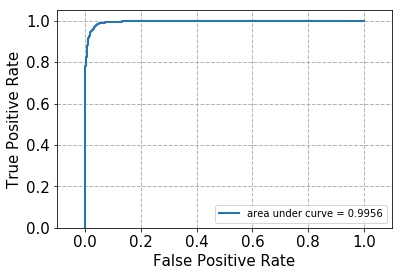

In [11]:
fit_predict_and_plot_roc(Hpipeline, train_dataset.data, y_train_dataset, test_dataset.data, y_test_dataset)

### Soft Margin ROC Plot

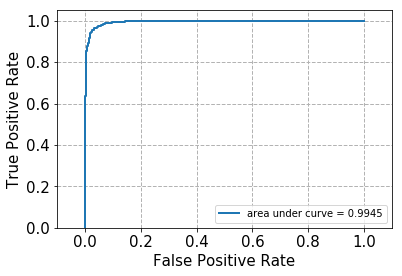

In [12]:
fit_predict_and_plot_roc(Spipeline, train_dataset.data, y_train_dataset, test_dataset.data, y_test_dataset)

### Hard/Soft Margin Confusion Matrix, Accuracy, Recall, Precision, and F1 Score

In [13]:
from sklearn.metrics import confusion_matrix

# predict class for test dataset
Hpredict = Hpipeline.predict(test_dataset.data)
Spredict = Spipeline.predict(test_dataset.data)

# compute confusion matrix
HconfMatrix = confusion_matrix(y_test_dataset, Hpredict)
SconfMatrix = confusion_matrix(y_test_dataset, Spredict)

#------------------------------------------------------------------------------#

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

# Hard Margin Confusion Matrix/Scores
print('HARD MARGIN SVM CLASSIFIER')
print('-'*25)
print('\nHard Margin Confusion Matrix:')
print(HconfMatrix)

# Hard Margin Scores
print('\nHard Margin Scores')
print("%-12s %f" % ('- Accuracy:', accuracy_score(y_test_dataset, Hpredict)))
print("%-12s %f" % ('- Recall:', recall_score(y_test_dataset, Hpredict)))
print("%-12s %f" % ('- Precision:', precision_score(y_test_dataset, Hpredict)))
print("%-12s %f" % ('- F-1:', f1_score(y_test_dataset, Hpredict)))

# Soft Margin Confusion Matrix/Scores
print('\n\nSOFT MARGIN SVM CLASSIFIER')
print('-'*25)
print('\nSoft Margin Confusion Matrix:')
print(SconfMatrix)

# Soft Margin Scores
print('\nSoft Margin Scores')
print("%-12s %f" % ('- Accuracy:', accuracy_score(y_test_dataset, Spredict)))
print("%-12s %f" % ('- Recall:', recall_score(y_test_dataset, Spredict)))
print("%-12s %f" % ('- Precision:', precision_score(y_test_dataset, Spredict)))
print("%-12s %f" % ('- F-1:', f1_score(y_test_dataset, Spredict)))

HARD MARGIN SVM CLASSIFIER
-------------------------

Hard Margin Confusion Matrix:
[[1496   64]
 [  34 1556]]

Hard Margin Scores
- Accuracy:  0.968889
- Recall:    0.978616
- Precision: 0.960494
- F-1:       0.969470


SOFT MARGIN SVM CLASSIFIER
-------------------------

Soft Margin Confusion Matrix:
[[   0 1560]
 [   0 1590]]

Soft Margin Scores
- Accuracy:  0.504762
- Recall:    1.000000
- Precision: 0.504762
- F-1:       0.670886


### Using Cross Validation to Choose Optimal Gamma

In [14]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import math

# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
# print(__doc__)
cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

Tpipeline = Pipeline([
    ('vect', CountVectorizer(min_df=3, stop_words='english',analyzer=stem_remove_punc)),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50)),
    ('toarr', SparseToDenseArray()),
    ('clf', SVC(kernel='linear', C=1000)),
],
memory=memory
)

# Gamma test set: {10^k | -3 <= k <= 3, k in Z}
#C_OPTIONS = {'C': [math.pow(10, k) for k in range(-3,3)]}

param_grid = [
    {
        'clf__C': [math.pow(10, k) for k in range(-3,3)]
    }
]

grid = GridSearchCV(Tpipeline, cv=5, n_jobs=1, param_grid=param_grid, scoring='accuracy')
grid.fit(train_dataset.data, y_train_dataset)

print("Best Parameters: ")
print(grid.best_params_)

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='C:\\Users\\ADMINI~1\\AppData\\Local\\Temp\\tmp4bjradg2'", use "location='C:\\Users\\ADMINI~1\\AppData\\Local\\Temp\\tmp4bjradg2'" instead.
  # This is added back by InteractiveShellApp.init_path()


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stem_remove_punc at 0x000000000B0351E0>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=3, ngram_range=(1, 1), preprocessor=None,
        stop_words='english', strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None), 
[ 'From: rschmitt@shearson.com (Robert Schmitt)\n'
  'Subject: Re: Please Recommend 3D Graphics Library F\n'
  'Reply-To: rschmitt@shearson.com\n'
  'Organization: Lehman Brothers, Inc.\n'
  'Lines: 9\n'
  '\n'
  'What hardware do plan to run on?  Workstation or PC?  Cost level?\n'
  'Run-time licensing needs?\n'
  '\n'
  'Bob\n'
  '------------------------------------------------------------------\n'
  'Robert A. S

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.37s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 66.4s, 1.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x14166 sparse matrix of type '<class 'numpy.int64'>'
	with 288278 stored elements in Compressed Sparse Row format>, 
array([0, ..., 0], dtype=int64), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0), 
<3785x14166 sparse matrix of type '<class 'numpy.float64'>'
	with 288278 stored elements in Compressed Sparse Row format>, 
array([0, ..., 0], dtype=int64), None)
_____________________

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.29s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 64.6s, 1.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x13749 sparse matrix of type '<class 'numpy.int64'>'
	with 283653 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0], dtype=int64), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0), 
<3785x13749 sparse matrix of type '<class 'numpy.float64'>'
	with 283653 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0], dtype=int64), None)
_____________________

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.36s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 65.4s, 1.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x14252 sparse matrix of type '<class 'numpy.int64'>'
	with 287786 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0], dtype=int64), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0), 
<3785x14252 sparse matrix of type '<class 'numpy.float64'>'
	with 287786 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0], dtype=int64), None)
_____________________

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.31s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 65.4s, 1.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x13840 sparse matrix of type '<class 'numpy.int64'>'
	with 286944 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0], dtype=int64), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0), 
<3786x13840 sparse matrix of type '<class 'numpy.float64'>'
	with 286944 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0], dtype=int64), None)
_____________________

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.43s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 63.5s, 1.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3787x13960 sparse matrix of type '<class 'numpy.int64'>'
	with 287874 stored elements in Compressed Sparse Row format>, 
array([1, ..., 1], dtype=int64), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0), 
<3787x13960 sparse matrix of type '<class 'numpy.float64'>'
	with 287874 stored elements in Compressed Sparse Row format>, 
array([1, ..., 1], dtype=int64), None)
_____________________

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\ADMINI~1\AppData\Local\Temp\tmp4bjradg2\joblib\sklearn\pipeline\_fit_transform_one\7a3c707847eae0e7865340006b76b5a1
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\ADMINI~1\AppData\Local\Temp\tmp4bjradg2\joblib\sklearn\pipeline\_fit_transform_one\aecb379108ca8d864a0679b9041e1ecf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\ADMINI~1\AppData\Local\Temp\tmp4bjradg2\joblib\sklearn\pipeline\_fit_transform_one\ec068c2de3dba3dfa94b692459bb3535
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\ADMINI~1\AppData\Local\Temp\tmp4bjradg2\joblib\sklearn\pipeline\_fit_transform_one\38218ce2cec7ac32bd91e61a52bc98b5
_________________________

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\ADMINI~1\AppData\Local\Temp\tmp4bjradg2\joblib\sklearn\pipeline\_fit_transform_one\c4de34882a41360480d0b218b5dcba9f
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\ADMINI~1\AppData\Local\Temp\tmp4bjradg2\joblib\sklearn\pipeline\_fit_transform_one\0f14909bbb743bdb05883ac009d73b41
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\ADMINI~1\AppData\Local\Temp\tmp4bjradg2\joblib\sklearn\pipeline\_fit_transform_one\15346557afa8bf00b53e918807efbfd2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\ADMINI~1\AppData\Local\Temp\tmp4bjradg2\joblib\sklearn\pipeline\_fit_transform_one\d53b10cb13afb4e4c7ba06851c02b90c
_________________________

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\ADMINI~1\AppData\Local\Temp\tmp4bjradg2\joblib\sklearn\pipeline\_fit_transform_one\b16e76b3401268255420f2c3caca38e2
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\ADMINI~1\AppData\Local\Temp\tmp4bjradg2\joblib\sklearn\pipeline\_fit_transform_one\c57c4b6b7c653bf72460fbffa40bc9ad
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\ADMINI~1\AppData\Local\Temp\tmp4bjradg2\joblib\sklearn\pipeline\_fit_transform_one\20b78197218f4fe42231f655a4e2ce65
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\ADMINI~1\AppData\Local\Temp\tmp4bjradg2\joblib\sklearn\pipeline\_fit_transform_one\36b8be5df96fa5c4481741b8bf68b658
_________________________

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.72s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 81.3s, 1.4min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <4732x16292 sparse matrix of type '<class 'numpy.int64'>'
	with 363811 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0], dtype=int64), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0), 
<4732x16292 sparse matrix of type '<class 'numpy.float64'>'
	with 363811 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0], dtype=int64), None)
_____________________

### Optimal Margin SVM

In [15]:
Optpipeline = Pipeline([
    ('vect', CountVectorizer(min_df=3, stop_words='english',analyzer=stem_remove_punc)),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', NMF(n_components=50, init='random', random_state=0)),
    ('toarr', SparseToDenseArray()),
    ('clf', SVC(kernel='linear', C=100)),
])

### Optimal Margin ROC

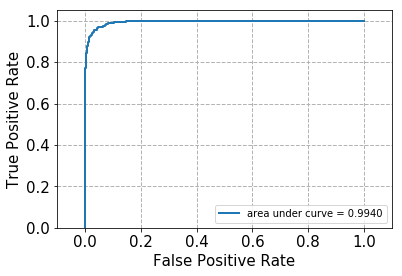

In [16]:
fit_predict_and_plot_roc(Optpipeline, train_dataset.data, y_train_dataset, test_dataset.data, y_test_dataset)

### Optimal Confusion Matrix, Accuracy, Recall, Precision, and F1 Score

In [17]:
# predict class for test dataset
Optpredict = Optpipeline.predict(test_dataset.data)

# compute confusion matrix
OptconfMatrix = confusion_matrix(y_test_dataset, Optpredict)

# Optimal Confusion Matrix/Scores
print('OPTIMAL SVM CLASSIFIER')
print('-'*25)
print('\nOptimal Confusion Matrix:')
print(OptconfMatrix)

# Optimal Margin Scores
print('\nOptimal Scores')
print("%-12s %f" % ('- Accuracy:', accuracy_score(y_test_dataset, Optpredict)))
print("%-12s %f" % ('- Recall:', recall_score(y_test_dataset, Optpredict)))
print("%-12s %f" % ('- Precision:', precision_score(y_test_dataset, Optpredict)))
print("%-12s %f" % ('- F-1:', f1_score(y_test_dataset, Optpredict)))

OPTIMAL SVM CLASSIFIER
-------------------------

Optimal Confusion Matrix:
[[1474   86]
 [  49 1541]]

Optimal Scores
- Accuracy:  0.957143
- Recall:    0.969182
- Precision: 0.947142
- F-1:       0.958035


## Question 5: Logistic Classifier (Chris)

Train a logistic classifier without regularization (you may need to come up with some way to approximate this if you use sklearn.linear_model.LogisticRegression); plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1 score of this classifier.

### Logistic Regression with No Penalty

Since sklearn's implementation of logistic regression does not give us the option of not using a regularizer, we can approximate this by setting the 'C' parameter to a very large number. 

In [18]:
# Combine sub-classes of docs into 'Computer Technology' and 'Recreational 
# Activity' using floor division such that when target is less than 4, it 
# becomes 0 and when it's between 4 and 7, it becomes 1
vfunc = np.vectorize(lambda target: target // 4)
y_train_dataset = vfunc(train_dataset.target)
y_test_dataset = vfunc(test_dataset.target)


# Logistic Regression
from sklearn.linear_model import LinearRegression, LogisticRegression

# Instantiate classifier, learn parameters, and predict class for test dataset
classifier = LogisticRegression(C=np.inf, solver='lbfgs')
classifier.fit(X_train_tfidf, y_train_dataset)
y_pred = classifier.predict(X_test_tfidf)
y_score = classifier.predict_proba(X_test_tfidf)

**Calculate ROC Curve**

Use roc_curve from sklearn

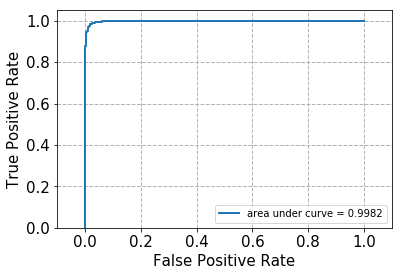

In [19]:
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Calculate fpr and tpr
fpr, tpr, _ = roc_curve(y_test_dataset, y_score[:,1])

# Function to plot ROC curve
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

# Call function to plot ROC
plot_roc(fpr, tpr)

**Confusion Matrix**

Code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

cm = confusion_matrix(y_test_dataset, y_pred)
print('Confusion Matrix for Logistic Regression Classifier')
print(cm)

Confusion Matrix for Logistic Regression Classifier
[[1507   53]
 [  17 1573]]


**Accuracy, Recall, Precision, and F-1 Score**

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

# Calculate accuracy
print("Accuracy: {}".format(accuracy_score(y_test_dataset, y_pred)))
print("Recall: {}".format(recall_score(y_test_dataset, y_pred)))
print("Precision: {}".format(precision_score(y_test_dataset, y_pred)))
print("F-1 Score: {}".format(f1_score(y_test_dataset, y_pred)))

Accuracy: 0.9777777777777777
Recall: 0.9893081761006289
Precision: 0.9674046740467405
F-1 Score: 0.9782338308457712


### Logistic Regression with Regularization
  * Using 5-fold cross-validation on the dimension-reduced-by-svd training data, find the best regularization strength in the range ... for logistic regression with L1 regularization and logistic regression L2 regularization, respectively.
  * Compare the performance (accuracy, precision, recall and F-1 score) of 3 logistic classifiers: w/o regularization, w/ L1 regularization and w/ L2 regularization (with the best parameters you found from the part above), using test data.
  * How does the regularization parameter affect the test error? How are the learnt coefficients affected? Why might one be interested in each type of regularization?
  * Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary, then what’s the difference between their ways to find this boundary? Why their performance differ?

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
import math

# Define parameter(s) to be used in the grid search
parameters = {'C': [math.pow(10,k) for k in range(-3,4)]}

# Create a grid search to find the best C value for L1 Penalty
grid_clf = GridSearchCV(LogisticRegression(penalty='l1', solver='liblinear'), 
                        parameters, cv=5)
grid_clf.fit(X_transformed, y_train_dataset)

print("Best Inverse Regularization strength for L1 Penalty: ")
print(grid_clf.best_params_)

# Create a grid search to find the best C value for L1 Penalty
grid_clf = GridSearchCV(LogisticRegression(penalty='l2', solver='lbfgs', 
                                           max_iter=200), parameters, cv=5)
grid_clf.fit(X_transformed, y_train_dataset)

print("Best Inverse Regularization strength for L2 Penalty: ")
print(grid_clf.best_params_)

Best Inverse Regularization strength for L1 Penalty: 
{'C': 10.0}
Best Inverse Regularization strength for L2 Penalty: 
{'C': 100.0}


* Compare the performance (accuracy, precision, recall and F-1 score) of 3 logistic classifiers: w/o regularization, w/ L1 regularization and w/ L2 regularization (with the best parameters you found from the part above), using test data.

### Question 6: Naive Bayes (Danny)